# Winning a Kaggle Competition in Python

[_"Kaggle is the most famous platform for Data Science competitions. Taking part in such competitions allows you to work with real-world datasets, explore various machine learning problems, compete with other participants and, finally, get invaluable hands-on experience. In this course, you will learn how to approach and structure any Data Science competition. You will be able to select the correct local validation scheme and to avoid overfitting. Moreover, you will master advanced feature engineering together with model ensembling approaches. All these techniques will be practiced on Kaggle competitions datasets"._](https://app.datacamp.com/learn/courses/winning-a-kaggle-competition-in-python)


##  1. Kaggle competitions process
In this first chapter, we will get exposure to the Kaggle competition process. We will train a model and prepare a csv file ready for submission. Moreover, we will learn the difference between Public and Private test splits, and how to prevent overfitting.

For this chaapter we will use data coming from the [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data).

### Training data exploration
We are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items in 10 different stores. To begin, we will explore the train data for this competition. For the faster performance, we will work with a subset of the train data containing only ~25% of it. Furthermore, we will split it into train and test. Our initial goal is to read the input data and take the first look at it.

In [1]:
# Install packages https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
# !conda install --yes --prefix {sys.prefix} pandas
# !conda install --yes --prefix {sys.prefix} mkl-service
# !conda install --yes --prefix {sys.prefix} numpy
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} scikit-learn
# !conda install --yes --prefix {sys.prefix} xgboost

In [54]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer # Import SimpleImputer
import xgboost as xgb
from math import sin, cos, sqrt, atan2, radians
import itertools
from datetime import datetime

In [3]:
# Read train data
store_item_dir = 'data/store_item_demand_forecasting_challenge/'
store_item_train = pd.read_csv(store_item_dir + 'train.csv')

# Look at the shape of the data
store_item_train = store_item_train[int(0.75*store_item_train.shape[0]):] # take the latest 25% of the data

print('Train shape:', store_item_train.shape)

# Look at the head() of the data
print(store_item_train.head())

Train shape: (228250, 4)
              date  store  item  sales
684750  2013-01-01      6    38     31
684751  2013-01-02      6    38     20
684752  2013-01-03      6    38     37
684753  2013-01-04      6    38     41
684754  2013-01-05      6    38     50


Having looked at the train data, let's explore the test data in the "Store Item Demand Forecasting Challenge". Remember, that the test dataset generally contains one column less than the train one.

In [4]:
# Read the test data
store_item_test = pd.read_csv(store_item_dir + 'test.csv')

# Print train and test columns
print('Train columns:', store_item_train.columns.tolist())
print('Test columns:', store_item_test.columns.tolist())

Train columns: ['date', 'store', 'item', 'sales']
Test columns: ['id', 'date', 'store', 'item']


Let's have a look at the submission file to get the output format for the Kaggle competition.

In [5]:
# Read the sample submission file
sample_submission = pd.read_csv(store_item_dir + 'sample_submission.csv')

# Look at the head() of the sample submission
print(sample_submission.head())

   id  sales
0   0     52
1   1     52
2   2     52
3   3     52
4   4     52


The sample submission file consists of two columns: `id` of the observation and `sales` column for our predictions. Kaggle will evaluate our predictions on the true `sales` data for the corresponding `id`. So, it’s important to keep track of the predictions by `id` before submitting them.

To determine a problem type let's explore the target variable `sales` in the the train dataset.

<AxesSubplot:>

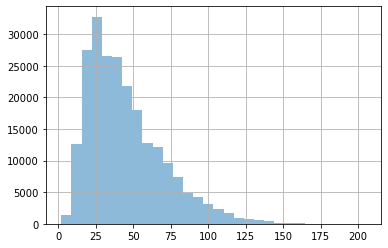

In [6]:
store_item_train.sales.hist(bins=30, alpha=0.5)

## Prepare a submission
The `sales` variable is continuous, so we're solving a regression problem. Now we're ready to build a model for a subsequent submission. For this exercise we will use `RandomForestRegressor` class from the `scikit-learn` library.

In [7]:
# Create a Random Forest object
rf = RandomForestRegressor()

# Train a model on the "store" and "item" features with "sales" as a target.
rf.fit(X=store_item_train[['store', 'item']], y=store_item_train['sales'])

# Get predictions for the test set
store_item_test['sales'] = rf.predict(store_item_test[['store', 'item']])

# Write test predictions using the sample_submission format (Note that sample submission has id and sales columns).
store_item_test[['id', 'sales']].to_csv('kaggle_submission.csv', index=False)

We've prepared our first Kaggle submission. Now, we could upload it to the Kaggle platform and see our score and current position on the Leaderboard. 

## Overfitting
Every Machine Learning method could potentially overfit. We will see it on this example with XGBoost. Firstly, let's train multiple XGBoost models with different sets of hyperparameters using XGBoost's learning API. The single hyperparameter we will change is:
- `max_depth` - maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

Since we don't have labels of the original `test` set, we will use the original `train` set for both, model training and evaluation. 

In [66]:
X_train, X_test, y_train, y_test = train_test_split(store_item_train[['store', 'item']], 
                                                    store_item_train['sales'], 
                                                    test_size=0.3, 
                                                    random_state=42)

# Create DMatrix on train data
dtrain = xgb.DMatrix(data = X_train,
                     label = y_train)

# Define xgboost parameters
params = {'objective': 'reg:squarederror',
          'max_depth': 2,
          'verbosity': 1}

# Train xgboost model
xg_depth_2 = xgb.train(params=params, dtrain=dtrain)


# Define xgboost parameters
params = {'objective': 'reg:squarederror',
          'max_depth': 8,
          'verbosity': 1}

# Train xgboost model
xg_depth_8 = xgb.train(params=params, dtrain=dtrain)

# Define xgboost parameters
params = {'objective': 'reg:squarederror',
          'max_depth': 15,
          'verbosity': 1}

# Train xgboost model
xg_depth_15 = xgb.train(params=params, dtrain=dtrain)

C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Having trained 3 XGBoost models with different maximum depths, we will now evaluate their quality. For this purpose, we will measure the quality of each model on both the train data and the test data. 

The goal of this exercise is to determine whether any of the models trained is overfitting. To measure the quality of the models we will use Mean Squared Error (MSE). It's available in `sklearn` metrics as `mean_squared_error()` function that takes two arguments: true values and predicted values.

In [67]:
# Create DMatrix on test data
dtest = xgb.DMatrix(data = X_test)

# For each of 3 trained models
for model in [xg_depth_2, xg_depth_8, xg_depth_15]:
    # make predictions
    train_pred = model.predict(dtrain)
    test_pred = model.predict(dtest)
    
    # calculate metrics
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    print('MSE Train: {:.3f}. MSE Test: {:.3f}'.format(mse_train, mse_test))

MSE Train: 329.748. MSE Test: 325.246
MSE Train: 195.908. MSE Test: 192.947
MSE Train: 195.534. MSE Test: 192.541


In these case we don't see an overfit since we don't have the real labels of the test set. However, this exercice was a good practice to conduct an overfit analysis.

# 2. Dive into the Competition

In the previous section we have practiced some basics of Kaggle competitions. In the correct section, we will learn how to study the specific problem at hand. We will practice EDA and get to establish correct local validation strategies. Moreover, we will also learn about data leakage. 

The data for this exercise is coming from the:
- [Two Sigma Connect: Rental Listing Inquiries](https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/overview). The problem definition is: _"Finding the perfect place to call your new home should be more than browsing through endless listings. RentHop makes apartment search smarter by using data to sort rental listings by quality. But while looking for the perfect apartment is difficult enough, structuring and making sense of all available real estate data programmatically is even harder. Two Sigma and RentHop, a portfolio company of Two Sigma Ventures, invite Kagglers to unleash their creative engines to uncover business value in this unique recruiting competition."_

- [New York City Taxi Fare Prediction](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview). The problem definition is: _"... you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of \\$5 - \\$10, depending on the model used. Your challenge is to do better than this using Machine Learning techniques!"_

## Define a competition metric
In this sub-section our goal is to manually develop a couple of competition metrics in case if they are not available in `sklearn.metrics`. In particular, we will define:
- Mean Squared Error (MSE) for the regression problem:
$$MSE = \frac{1}{N} \displaystyle\sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$

- Logarithmic Loss (LogLoss) for the binary classification problem:
$$LogLoss = -\frac{1}{N} \displaystyle\sum_{i=1}^{N} (y_i \ln p_i + (1-y_i) \ln (1-p_i)) $$

In [10]:
# Define our own MSE function
def own_mse(y_true, y_pred):
    # Raise differences to the power of 2
    squares = np.power(y_true - y_pred, 2)
    # Find mean over all observations
    err = np.mean(squares)
    return err

# Define our own LogLoss function
def own_logloss(y_true, prob_pred):
    # Find loss for each observation
    terms = y_true * np.log(prob_pred) + (1 - y_true) * np.log(1 - prob_pred)
    # Find mean over all observations
    err = np.mean(terms) 
    return -err

## EDA statistics
We will work with New York City taxi fare prediction data. We will start with finding some basic statistics about the data. Then we will move forward to plot some dependencies and generate hypotheses on them.

In [11]:
# Read train and test data
ny_taxi_dir = 'data/new_york_city_taxi_fare_prediction/'
ny_taxi_train = pd.read_csv(ny_taxi_dir + 'train_short.csv') # the original file consists of more than 55 million rows (~5 GB)
ny_taxi_test = pd.read_csv(ny_taxi_dir + 'test.csv')

In [12]:
# Shapes of train and test data
print('Train shape:', ny_taxi_train.shape)
print('Test shape:', ny_taxi_test.shape)

# Train head()
display(ny_taxi_train.head())

Train shape: (200001, 8)
Test shape: (9914, 7)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [13]:
ny_taxi_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200001 entries, 0 to 200000
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200001 non-null  object 
 1   fare_amount        200001 non-null  float64
 2   pickup_datetime    200001 non-null  object 
 3   pickup_longitude   200001 non-null  float64
 4   pickup_latitude    200001 non-null  float64
 5   dropoff_longitude  200000 non-null  float64
 6   dropoff_latitude   200000 non-null  float64
 7   passenger_count    200001 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 12.2+ MB


In [71]:
# Describe the target variable
print(ny_taxi_train.fare_amount.describe())

# Distribution of passengers within rides
print(ny_taxi_train.passenger_count.value_counts())

count    200000.000000
mean         11.342869
std           9.837854
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64
1    138538
2     29463
5     14197
3      8681
4      4225
6      4183
0       713
Name: passenger_count, dtype: int64


## EDA plots
After generating a couple of basic statistics, it's time to come up with and validate some ideas about the data dependencies. To begin with, let's make a scatterplot plotting the relationship between the fare amount and the distance of the ride. Intuitively, the longer the ride, the higher its price.

In [15]:
def dist_km(df):
    """
    This function takes the longitude and latitude coordinates
    of the origin and destination, and returns the distance in km between the two.
    Originally taken from: 
    https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

    Parameters
    ----------
    df.pickup_longitude : float
        origin longitude.
    df.pickup_latitude : float
        origin latitude.
    df.dropoff_longitude : float
        destination longitude.
    df.dropoff_latitude : float
        destination latitude.

    Returns
    -------
    float
        distance in km between the two locations.
    """
    # approximate radius of earth in km
    R = 6373.0


    lat1 = df.pickup_latitude.map(radians)
    lon1 = df.pickup_longitude.map(radians)
    lat2 = df.dropoff_latitude.map(radians)
    lon2 = df.dropoff_longitude.map(radians)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)

    distance = R * c
    
    return distance

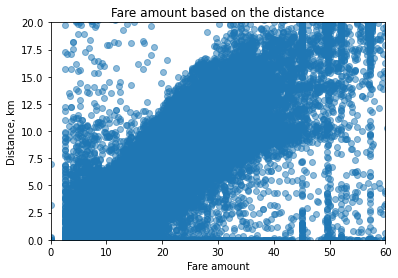

In [16]:
# Calculate the ride distance
ny_taxi_train['distance_km'] = dist_km(ny_taxi_train)

# Draw a scatterplot
plt.scatter(x=ny_taxi_train['fare_amount'],
            y=ny_taxi_train['distance_km'],
            alpha=0.5)
plt.xlabel('Fare amount')
plt.ylabel('Distance, km')
plt.title('Fare amount based on the distance')

# Limit on the distance and fare amount
plt.ylim(0, 20)
plt.xlim(0, 60)
plt.show()

It's obvious now that there is a clear dependency between ride distance and fare amount. So, ride distance is, probably, a good feature. Let's find some others!

Another idea that comes to mind is that the price of a ride could change during the day. Our goal is to plot the median fare amount for each hour of the day as a simple line plot.

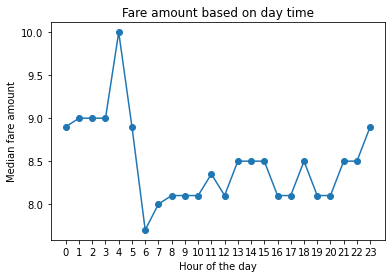

In [17]:
# Create hour feature
ny_taxi_train['pickup_datetime'] = pd.to_datetime(ny_taxi_train.pickup_datetime)
ny_taxi_train['hour'] = ny_taxi_train.pickup_datetime.dt.hour

# Find median fare_amount for each hour
hour_price = ny_taxi_train.groupby('hour', as_index=False)['fare_amount'].median()

# Plot the line plot
plt.plot(hour_price['hour'], hour_price['fare_amount'], marker='o')
plt.xlabel('Hour of the day')
plt.ylabel('Median fare amount')
plt.title('Fare amount based on day time')
plt.xticks(range(24))
plt.show()

We see that prices are a bit higher during the night. It is a good indicator that we should include the `"hour"` feature in the final model, or at least add a binary feature `"is_night"`. 

## K-fold cross-validation

We will start by getting hands-on experience in the most commonly used K-fold cross-validation.

The data we will be working with is from the "Two sigma connect: rental listing inquiries" Kaggle competition. The competition problem is a multi-class classification of the rental listings into 3 classes: low interest, medium interest and high interest. For faster performance, we will work with a subsample consisting of 1,000 observations.

In [18]:
# Read train and test data
two_sig_dir = 'data/two_sigma_connect_rental_listing_inquiries/'
two_sig_train = pd.read_json(two_sig_dir + 'train.json')
two_sig_train = two_sig_train[:1000]
print(two_sig_train.shape)
display(two_sig_train.head())

(1000, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


In [72]:
# Create a KFold object
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Loop through each split
fold = 0
for train_index, test_index in kf.split(two_sig_train):
    # Obtain training and testing folds
    cv_train, cv_test = two_sig_train.iloc[train_index], two_sig_train.iloc[test_index]
    print('Fold: {}'.format(fold))
    print('CV train shape: {}'.format(cv_train.shape))
    print('Medium interest listings in CV train: {}\n'.format(sum(cv_train.interest_level == 'medium')))
    fold += 1

Fold: 0
CV train shape: (666, 15)
Medium interest listings in CV train: 177

Fold: 1
CV train shape: (667, 15)
Medium interest listings in CV train: 163

Fold: 2
CV train shape: (667, 15)
Medium interest listings in CV train: 176



So, we see that the number of observations in each fold is almost uniform. It means that we've just splitted the train data into 3 equal folds. However, if we look at the number of medium-interest listings, it's varying from 162 to 175 from one fold to another. To make them uniform among the folds, let's use Stratified K-fold!

## Stratified K-fold
As we've just noticed, we have a pretty different target variable distribution among the folds due to the random splits. It's not crucial for this particular competition, but could be an issue for the classification competitions with the highly imbalanced target variable.

To overcome this, let's implement the stratified K-fold strategy with the stratification on the target variable. 

In [20]:
# Create a StratifiedKFold object
str_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Loop through each split
fold = 0
for train_index, test_index in str_kf.split(two_sig_train, two_sig_train['interest_level']):
    # Obtain training and testing folds
    cv_train, cv_test = two_sig_train.iloc[train_index], two_sig_train.iloc[test_index]
    print('Fold: {}'.format(fold))
    print('CV train shape: {}'.format(cv_train.shape))
    print('Medium interest listings in CV train: {}\n'.format(sum(cv_train.interest_level == 'medium')))
    fold += 1

Fold: 0
CV train shape: (666, 15)
Medium interest listings in CV train: 172

Fold: 1
CV train shape: (667, 15)
Medium interest listings in CV train: 172

Fold: 2
CV train shape: (667, 15)
Medium interest listings in CV train: 172



Now we see that both size and target distribution are the same among the folds. The general rule is to __prefer Stratified K-Fold__ over usual K-Fold in any classification problem. 

## Time K-fold

The "Store Item Demand Forecasting Challenge" is a competition with time series data where we should predict future sales. So, time K-fold cross-validation should be applied. Our goal is to create this cross-validation strategy and make sure that it works as expected.

In [21]:
# Read train 
store_demand_dir = 'data/store_item_demand_forecasting_challenge/'
store_demand_train = pd.read_csv(store_demand_dir + 'train.csv', nrows=15500)
print(store_demand_train.shape)
display(store_demand_train.head())

(15500, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [22]:
# Create TimeSeriesSplit object
time_kfold = TimeSeriesSplit(n_splits=3)

# Sort train data by date
store_demand_train = store_demand_train.sort_values('date')

# Iterate through each split
fold = 0
for train_index, test_index in time_kfold.split(store_demand_train):
    cv_train, cv_test = store_demand_train.iloc[train_index], store_demand_train.iloc[test_index]
    
    print('Fold :', fold)
    print('Train date range: from {} to {}'.format(cv_train.date.min(), cv_train.date.max()))
    print('Test date range: from {} to {}\n'.format(cv_test.date.min(), cv_test.date.max()))
    fold += 1

Fold : 0
Train date range: from 2013-01-01 to 2014-03-07
Test date range: from 2014-03-07 to 2015-05-12

Fold : 1
Train date range: from 2013-01-01 to 2015-05-12
Test date range: from 2015-05-12 to 2016-09-03

Fold : 2
Train date range: from 2013-01-01 to 2016-09-03
Test date range: from 2016-09-03 to 2017-12-31



We have applied time K-fold cross-validation strategy for the demand forecasting. The output works as expected, training only on the past data and predicting the future.

## Overall validation score

Now it's time to get the actual model performance using cross-validation! How does our store item demand prediction model perform?

Our task is to take the Mean Squared Error (MSE) for each fold separately, and then combine these results into a single number.

We will use the `get_fold_mse()` function that for each cross-validation split, fits a Random Forest model and returns a list of MSE scores by fold. `get_fold_mse()` accepts two arguments: train and TimeSeriesSplit object.

In [23]:
def get_fold_mse(train, kf):
    """
    The function was taken from:
    https://campus.datacamp.com/courses/winning-a-kaggle-competition-in-python/dive-into-the-competition?ex=13
    
    This function does the following:
    - for each cross-validation split fits a Random Forest model
    - and returns a list of MSE scores by fold. 
    
    Parameters
    ----------
    train: DataFrame
        training data.
    kf : TimeSeriesSplit objec
        objec for cross validation.

    Returns
    -------
    array
        mse scores of all folds.
    
    """
    
    mse_scores = []
    
    for train_index, test_index in kf.split(train):
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, random_state=123)

        # Train a model
        rf.fit(X=fold_train[['store', 'item']], y=fold_train['sales'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[['store', 'item']])
    
        fold_score = round(mean_squared_error(fold_test['sales'], pred), 5)
        mse_scores.append(fold_score)
        
    return mse_scores

In [24]:

# Initialize 3-fold time cross-validation
kf = TimeSeriesSplit(n_splits=3)

# Get MSE scores for each cross-validation split
mse_scores = get_fold_mse(store_demand_train, kf)

print('Mean validation MSE: {:.5f}'.format(np.mean(mse_scores)))
print('MSE by fold: {}'.format(mse_scores))
print('Overall validation MSE: {:.5f}'.format(np.mean(mse_scores) + np.std(mse_scores)))

Mean validation MSE: 87.85017
MSE by fold: [70.66459, 41.35682, 151.52911]
Overall validation MSE: 134.44053


Now, we know different validation strategies as well as how to use them to obtain overall model performance. It's time for the next and the most interesting part of the solution process: Feature Engineering and Modeling.

# 3. Feature Engineering

Now that we know the basics of Kaggle competitions, we will learn how to study the specific problem at hand. We will practice EDA and get to establish correct local validation strategies. Moreover, we will learn about data leakage.

## Arithmetical features

To practice creating new features, we will be working with a subsample from the Kaggle competition called ["House Prices: Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The goal of this competition is to predict the price of the house based on its properties. It's a regression problem with Root Mean Squared Error as an evaluation metric.

Our goal is to create new features and determine whether they improve our validation score. To get the validation score from 5-fold cross-validation, we will use `get_kfold_rmse()` function with the `train` DataFrame.

In [25]:
def get_kfold_rmse(train):
    """
    The function was taken from:
    https://campus.datacamp.com/courses/winning-a-kaggle-competition-in-python/feature-engineering-9e20ff8d-821e-4fcf-9c63-02f4b58dcdc2?ex=2
    
    This function does the following:
    - Takes a train DataFrame from the "House Prices: Advanced Regression Techniques" Kaggle competition
    - and returns a list of MSE scores by fold (assuming that the KFold object exists). 
    
    Parameters
    ----------
    train: DataFrame
        training data.

    Returns
    -------
    array
        mse scores of all folds.
    
    """
    
    mse_scores = []

    for train_index, test_index in kf.split(train):
        train = train.fillna(0)
        feats = [x for x in train.columns if x not in ['Id', 'SalePrice', 'RoofStyle', 'CentralAir']]
        
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, min_samples_split=10, random_state=42)

        # Train a model
        rf.fit(X=fold_train[feats], y=fold_train['SalePrice'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[feats])
    
        fold_score = mean_squared_error(fold_test['SalePrice'], pred)
        mse_scores.append(np.sqrt(fold_score))
        
    return round(np.mean(mse_scores) + np.std(mse_scores), 2)


In [74]:
# Read train and test data
house_prices_dir = 'data/house_prices_advanced_regression_techniques/'
house_prices_train = pd.read_csv(house_prices_dir + 'train.csv')

# take only part of the data
house_prices_train = house_prices_train[['Id', 'LotArea', 'OverallQual', 'YearBuilt',
                                         'RoofStyle', 'TotalBsmtSF', 'CentralAir',
                                         '1stFlrSF', '2ndFlrSF', 'FullBath',
                                         'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                                         'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice']]
print(house_prices_train.shape)
display(house_prices_train.head())

(1460, 17)


,Id,LotArea,OverallQual,YearBuilt,RoofStyle,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,1,8450,7,2003,Gable,856,Y,856,854,2,1,3,1,8,2,548,208500
1,2,9600,6,1976,Gable,1262,Y,1262,0,2,0,3,1,6,2,460,181500
2,3,11250,7,2001,Gable,920,Y,920,866,2,1,3,1,6,2,608,223500
3,4,9550,7,1915,Gable,756,Y,961,756,1,0,3,1,7,3,642,140000
4,5,14260,8,2000,Gable,1145,Y,1145,1053,2,1,4,1,9,3,836,250000


<AxesSubplot:>

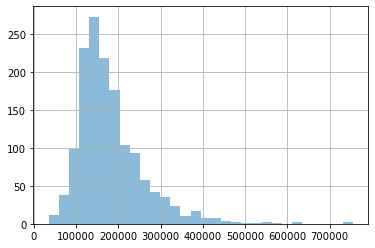

In [27]:
# To determine a problem type let's explore the target variable "SalePrice" in the the train dataset.
house_prices_train.SalePrice.hist(bins=30, alpha=0.5)

In [28]:
# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Look at the initial RMSE
print('RMSE before feature engineering:', get_kfold_rmse(house_prices_train))

RMSE before feature engineering: 39370.14


Now, we will create a new feature representing the total area (basement, 1st and 2nd floors) of the house. The columns `"TotalBsmtSF"`, `"1stFlrSF"` and `"2ndFlrSF"` give the areas of the basement, 1st and 2nd floors, respectively.

In [29]:
# Find the total area of the house
house_prices_train['TotalArea'] = house_prices_train[["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"]].sum(axis = 1, skipna = True) # sum over the column axis.

# Look at the updated RMSE
print('RMSE with total area:', get_kfold_rmse(house_prices_train))

RMSE with total area: 39530.75


Next, we will create a new feature representing the area of the garden. It is a difference between the total area of the property (`"LotArea"`) and the first floor area (`"1stFlrSF"`).

In [30]:
# Find the area of the garden
house_prices_train['GardenArea'] = house_prices_train["LotArea"] - house_prices_train["1stFlrSF"]
print('RMSE with garden area:', get_kfold_rmse(house_prices_train))

RMSE with garden area: 40384.66


Finally, we will create a new feature representing the total number of bathrooms in the house. It is a sum of full bathrooms (`"FullBath"`) and half bathrooms (`"HalfBath"`).

In [31]:
# Find total number of bathrooms
house_prices_train['TotalBath'] = house_prices_train[["FullBath","HalfBath"]].sum(axis=1, skipna = True)
print('RMSE with number of bathrooms:', get_kfold_rmse(house_prices_train))

RMSE with number of bathrooms: 39241.12


We've created three new features. However, in our case the RMSE has not changed significantly. The new features are not contributing, thus we can ignore them. Let's now work with the datetime features!

## Date features

We've built some basic features using numerical variables. Now, it's time to create features based on date and time. We will practice on a subsample from the Taxi Fare Prediction Kaggle competition data. The data represents information about the taxi rides and the goal is to predict the price for each ride.

Our objective is to generate date features from the pickup datetime. Recall that it's better to create new features for train and test data simultaneously. After the features are created, split the data back into the train and test DataFrames. Here it's done using `pandas`' `isin()` method.

In [32]:
# read train and test data
ny_taxi_train = pd.read_csv(ny_taxi_dir + 'train_short.csv') 
ny_taxi_test = pd.read_csv(ny_taxi_dir + 'test.csv')

# Concatenate train and test together
taxi = pd.concat([ny_taxi_train, ny_taxi_test])

# Convert pickup date to datetime object
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])

# Create a day of week feature
taxi['dayofweek'] = taxi['pickup_datetime'].dt.dayofweek

# Create an hour feature
taxi['hour'] = taxi['pickup_datetime'].dt.hour

# Split back into train and test
new_ny_taxi_train = taxi[taxi['key'].isin(ny_taxi_train['key'])]
new_ny_taxi_test = taxi[taxi['key'].isin(ny_taxi_test['key'])]

Now we know how to perform feature engineering for train and test DataFrames simultaneously. Having considered numerical and datetime features.

## Label encoding

Let's work on categorical variables encoding. We will again work with a subsample from the House Prices Kaggle competition. Our objective is to encode categorical features `"RoofStyle"` and `"CentralAir"` using label encoding. 

In [76]:
# Load and concatenate train and test together
house_prices_train = pd.read_csv(house_prices_dir + 'train.csv')
house_prices_test = pd.read_csv(house_prices_dir + 'test.csv')
houses = pd.concat([house_prices_train, house_prices_test])

# Label encoder
le = LabelEncoder()

# Create new features
houses['RoofStyle_enc'] = le.fit_transform(houses["RoofStyle"])
houses['CentralAir_enc'] = le.fit_transform(houses["CentralAir"])

# Look at new features
print(houses[['RoofStyle', 'RoofStyle_enc', 'CentralAir', 'CentralAir_enc']].head())

  RoofStyle  RoofStyle_enc CentralAir  CentralAir_enc
0     Gable              1          Y               1
1     Gable              1          Y               1
2     Gable              1          Y               1
3     Gable              1          Y               1
4     Gable              1          Y               1


We can see that categorical variables have been label encoded. However, as we already know, label encoder is not always a good choice for categorical variables. Let's go further and apply One-Hot encoding.

## One-Hot encoding

The problem with label encoding is that it implicitly assumes that there is a ranking dependency between the categories. So, let's change the encoding method for the features "RoofStyle" and "CentralAir" to one-hot encoding. 

Recall that if we're dealing with __binary features__ (categorical features with only two categories) it is suggested to apply __label encoder only__. Our goal is to determine which of the mentioned features is not binary, and to apply one-hot encoding only to this one.

In [77]:
# Look at feature distributions
print(houses['RoofStyle'].value_counts(), '\n')
print(houses['CentralAir'].value_counts())

Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64 

Y    2723
N     196
Name: CentralAir, dtype: int64


As long as `"CentralAir"` is a binary feature, we encode it with a label encoder (0 - for one class and 1 - for another class). For the categorical feature `"RoofStyle"` let's use the one-hot encoder. Firstly, we will create one-hot encoded features using the `get_dummies()` method. Then they we will concatenate to the initial `houses` DataFrame.

In [78]:
# Create One-Hot encoded features
ohe = pd.get_dummies(houses['RoofStyle'], prefix='RoofStyle')

# Concatenate OHE features to houses
houses = pd.concat([houses, ohe], axis=1)

# Look at OHE features
display(houses[[col for col in houses.columns if 'RoofStyle' in col]].head(3))

,RoofStyle,RoofStyle_enc,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
0,Gable,1,0,1,0,0,0,0
1,Gable,1,0,1,0,0,0,0
2,Gable,1,0,1,0,0,0,0


Now we've mastered one-hot encoding as well! The one-hot encoded features look as expected. Remember to drop the initial string column, because models will not handle it automatically. OK, we're done with simple categorical encoders. Let's move to the target encoder!

## Mean target encoding

First of all, we will create a function that implements mean target encoding. Remember that we need to develop the two following steps:

1. Calculate the mean on the train, apply to the test
1. Split train into K folds. Calculate the out-of-fold mean for each fold, apply to this particular fold

Each of these steps will be implemented in a separate function: `test_mean_target_encoding()` and `train_mean_target_encoding()`, respectively.

The final function `mean_target_encoding()` takes as arguments: the train and test DataFrames, the name of the categorical column to be encoded, the name of the target column and a smoothing parameter alpha. It returns two values: a new feature for train and test DataFrames, respectively.

In [36]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values


def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values


def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

Now we are equipped with a function that performs mean target encoding of any categorical feature. Move on to learn how to implement mean target encoding for the K-fold cross-validation using the `mean_target_encoding()` function we've just built!

## K-fold cross-validation

We will work with a binary classification problem on a subsample from Kaggle playground competition, [Kobe Bryant Shot Selection](https://www.kaggle.com/c/kobe-bryant-shot-selection/data). The objective of this competition is to predict whether a famous basketball player Kobe Bryant scored a basket or missed a particular shot.

The target variable `"shot_made_flag"` -- whether shot was scored or not. One of the features in the data is `"game_id"` -- a particular game where the shot was made. There are __541__ distinct games. So, we deal with a high-cardinality categorical feature. Let's encode it using a target mean!

Suppose we're using 5-fold cross-validation and want to evaluate a mean target encoded feature on the local validation.

In [37]:
# Read data 
bryant_shots_dir = 'data/kobe_bryant_shot_selection/'
bryant_shots_data = pd.read_csv(bryant_shots_dir + 'data.csv', nrows=10000)
print(bryant_shots_data.shape)
display(bryant_shots_data.head())

(10000, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [38]:
# Create 5-fold cross-validation
kf = KFold(n_splits=5, random_state=123, shuffle=True)

# For each folds split
for train_index, test_index in kf.split(bryant_shots_data):
    cv_train, cv_test = bryant_shots_data.iloc[train_index], bryant_shots_data.iloc[test_index]

    # Create mean target encoded feature
    cv_train['game_id_enc'], cv_test['game_id_enc'] = mean_target_encoding(train=cv_train,
                                                                           test=cv_test,
                                                                           target='shot_made_flag',
                                                                           categorical='game_id',
                                                                           alpha=5)
    # Look at the encoding
    print(cv_train[['game_id', 'shot_made_flag', 'game_id_enc']].sample(n=1))

       game_id  shot_made_flag  game_id_enc
1764  20100204             NaN     0.401707
       game_id  shot_made_flag  game_id_enc
7998  20500251             1.0     0.513096


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_9000\3451765290.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_feature = pd.Series(index=train.index)
C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_9000\2804302140.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_train['game_id_enc'], cv_test['game_id_enc'] = mean_target_encoding(train=cv_train,
C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_9000\2804302140.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

       game_id  shot_made_flag  game_id_enc
1143  20000739             0.0      0.28199
       game_id  shot_made_flag  game_id_enc
5804  20300926             0.0     0.306273
      game_id  shot_made_flag  game_id_enc
415  20000258             1.0     0.532664


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_9000\3451765290.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_feature = pd.Series(index=train.index)
C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_9000\2804302140.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_train['game_id_enc'], cv_test['game_id_enc'] = mean_target_encoding(train=cv_train,
C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_9000\2804302140.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

We could see different game encodings for each validation split in the output. The main conclusion we should make: while using local cross-validation, we need to repeat mean target encoding procedure inside each folds split separately. 

## Beyond binary classification

Of course, binary classification is just a single special case. Target encoding could be applied to any target variable type:

- For binary classification usually mean target encoding is used
- For regression mean could be changed to median, quartiles, etc.
- For multi-class classification with N classes we create N features with target mean for each category in one vs. all fashion

The `mean_target_encoding()` could be used for any target type specified above. Let's apply it for the regression problem on the example of House Prices Kaggle competition. Our goal is to encode a categorical feature `"RoofStyle"` using mean target encoding. 

In [39]:
# Create mean target encoded feature
house_prices_train['RoofStyle_enc'], house_prices_test['RoofStyle_enc'] = mean_target_encoding(train=house_prices_train,
                                                                     test=house_prices_test,
                                                                     target="SalePrice",
                                                                     categorical="RoofStyle",
                                                                     alpha=10)

# Look at the encoding
print(house_prices_test[['RoofStyle', 'RoofStyle_enc']].drop_duplicates())

     RoofStyle  RoofStyle_enc
0        Gable  171565.947836
1          Hip  217594.645131
98     Gambrel  164152.950424
133       Flat  188703.563431
362    Mansard  180775.938759
1053      Shed  188267.663242


C:\Users\DmitriGazizulin\AppData\Local\Temp\ipykernel_9000\3451765290.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_feature = pd.Series(index=train.index)


So, we observe that houses with the `Hip` roof are the most pricy, while houses with the `Gambrel` roof are the cheapest. It's exactly the goal of target encoding: we've encoded categorical feature in such a manner that there is now a correlation between category values and target variable. We're done with categorical encoders. Now it's time to talk about the missing data!

## Find missing data

Let's impute missing data on a real Kaggle dataset. For this purpose, we will be using a data subsample from the Kaggle "Two sigma connect: rental listing inquiries" competition.

Before proceeding with any imputing we need to know the number of missing values for each of the features. Moreover, if the feature has missing values, we should explore the type of this feature.

In [40]:
# filling NaNs for this exercise
two_sig_train.loc[two_sig_train.sample(frac=0.1).index, 'building_id'] = np.nan
two_sig_train.loc[two_sig_train.sample(frac=0.15).index, 'price'] = np.nan

In [41]:
# Find the number of missing values in each column
print(two_sig_train.isnull().sum())

bathrooms            0
bedrooms             0
building_id        100
created              0
description          0
display_address      0
features             0
latitude             0
listing_id           0
longitude            0
manager_id           0
photos               0
price              150
street_address       0
interest_level       0
dtype: int64


In [42]:
# Look at the columns with the missing values
print(two_sig_train[['building_id', 'price']].head())

                         building_id   price
4   8579a0b0d54db803821a35a4a615e97a  2400.0
6   b8e75fc949a6cd8225b455648a951712     NaN
9   cd759a988b8f23924b5a2058d5ab2b49  3495.0
10  53a5b119ba8f7b61d4e010512e0dfc85  3000.0
15  bfb9405149bfff42a92980b594c28234     NaN


All right, we've found out that `'building_id'` and `'price'` columns have missing values. Looking at the head of the DataFrame, we may conclude that `'price'` is a numerical feature, while `'building_id'` is a categorical feature that is encoding buildings as hashes.

## Impute missing data

We've found that `"price"` and `"building_id"` columns have missing values in the Rental Listing Inquiries dataset. So, before passing the data to the models we need to impute these values.

Numerical feature `"price"` will be encoded with a mean value of non-missing prices.

Imputing categorical feature `"building_id"` with the most frequent category is a bad idea, because it would mean that all the apartments with a missing `"building_id"` are located in the most popular building. The better idea is to impute it with a new category.

In [43]:
# Create mean imputer
mean_imputer = SimpleImputer(strategy='mean')

# Price imputation
two_sig_train[['price']] = mean_imputer.fit_transform(two_sig_train[['price']])

# Create constant imputer
constant_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

# building_id imputation
two_sig_train[['building_id']] = constant_imputer.fit_transform(two_sig_train[['building_id']])

print(two_sig_train[['building_id', 'price']].isnull().sum())

building_id    0
price          0
dtype: int64


Now our data is ready to be passed to any Machine Learning model.

# 4. Modeling

Time to bring everything together and build some models! In this last chapter, we will build a base model before tuning some hyperparameters and improving our results with ensembles. We will then get some final tips and tricks to help us compete more efficiently.

## Replicate validation score

Throughout this chapter, we will work with New York City Taxi competition data. The problem is to predict the fare amount for a taxi ride in New York City. The competition metric is the root mean squared error.

The first goal is to evaluate the Baseline model on the validation data. We will replicate the simplest Baseline based on the mean of `"fare_amount"`. 

In [44]:
#  Create local validation
local_validation_ny_taxi_train, local_validation_ny_taxi_test = train_test_split(ny_taxi_train, 
                                                                                 test_size=0.3, 
                                                                                 random_state=42)

In [45]:
# Calculate the mean fare_amount on the validation_train data
naive_prediction = np.mean(local_validation_ny_taxi_train['fare_amount'])

# Assign naive prediction to all the holdout observations
local_validation_ny_taxi_test['pred'] = naive_prediction

# Measure the local RMSE
rmse_mean = sqrt(mean_squared_error(local_validation_ny_taxi_test['fare_amount'], 
                                    local_validation_ny_taxi_test['pred']))
print('Validation RMSE for Baseline I model: {:.3f}'.format(rmse_mean))

Validation RMSE for Baseline I model: 9.810


## Baseline based on the date

To get more practice, let's build a couple more baseline models. The next baseline model is based on the grouping variables. It's clear that the ride fare could depend on the part of the day. For example, prices could be higher during the rush hours. Our goal is to build a baseline model that will assign the average `"fare_amount"` for the corresponding hour. 

In [46]:
# Convert pickup date to datetime object
local_validation_ny_taxi_train['pickup_datetime'] = pd.to_datetime(local_validation_ny_taxi_train['pickup_datetime'])
local_validation_ny_taxi_test['pickup_datetime'] = pd.to_datetime(local_validation_ny_taxi_test['pickup_datetime'])

# Check is types of the columns
local_validation_ny_taxi_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140000 entries, 113288 to 121958
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                140000 non-null  object             
 1   fare_amount        140000 non-null  float64            
 2   pickup_datetime    140000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   140000 non-null  float64            
 4   pickup_latitude    140000 non-null  float64            
 5   dropoff_longitude  140000 non-null  float64            
 6   dropoff_latitude   140000 non-null  float64            
 7   passenger_count    140000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 9.6+ MB


In [47]:
# Get pickup hour from the pickup_datetime column
local_validation_ny_taxi_train['hour'] = local_validation_ny_taxi_train['pickup_datetime'].dt.hour
local_validation_ny_taxi_test['hour'] = local_validation_ny_taxi_test['pickup_datetime'].dt.hour

# Calculate average fare_amount grouped by pickup hour 
hour_groups = local_validation_ny_taxi_train.groupby('hour')['fare_amount'].mean()
display(hour_groups)

# Make predictions on the test set
local_validation_ny_taxi_test['pred'] = local_validation_ny_taxi_test.hour.map(hour_groups)
# Measure the local RMSE
rmse_group = sqrt(mean_squared_error(local_validation_ny_taxi_test['fare_amount'], 
                                     local_validation_ny_taxi_test['pred']))
print('Validation RMSE for Baseline II model: {:.3f}'.format(rmse_group))

hour
0     11.512535
1     11.609068
2     11.646396
3     12.003251
4     13.741648
5     14.526188
6     12.144416
7     10.945939
8     10.832683
9     10.780053
10    10.961344
11    11.356686
12    11.131416
13    11.553612
14    12.066149
15    12.043811
16    11.876399
17    11.224306
18    10.959636
19    10.683493
20    10.834299
21    11.104655
22    11.203855
23    11.537998
Name: fare_amount, dtype: float64

Validation RMSE for Baseline I model: 9.790


This results is slightly better than prediction by mean.

## Baseline based on the gradient boosting

Let's build a final baseline based on the Random Forest to further improve this score.

The goal of this exercise is to take numeric features and train a Random Forest model without any tuning. After that, we could make test predictions and validate the result. Note that we've already got an `"hour"` feature which could also be used as an input to the model.

In [48]:
local_validation_ny_taxi_test.dropna(inplace=True)
local_validation_ny_taxi_test.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
pred                 0
hour                 0
dtype: int64

In [49]:
# Select only numeric features
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
            'dropoff_latitude', 'passenger_count', 'hour']

# Train a Random Forest model
rf = RandomForestRegressor()
rf.fit(local_validation_ny_taxi_train[features], local_validation_ny_taxi_train.fare_amount)

# Make predictions on the test data
local_validation_ny_taxi_test['pred'] = rf.predict(local_validation_ny_taxi_test[features])

# Measure the local RMSE
rmse_rf = sqrt(mean_squared_error(local_validation_ny_taxi_test['fare_amount'], 
                                  local_validation_ny_taxi_test['pred']))
print('Validation RMSE for Baseline I model: {:.3f}'.format(rmse_rf))

Validation RMSE for Baseline I model: 4.921


This final baseline achieves the best score. So, now we know how to build fast and simple baseline models to validate our initial pipeline.

## Grid search

In the previous subsection we've created a baseline Gradient Boosting model. Our goal now is to find the best `max_depth` hyperparameter value for this Gradient Boosting model. This hyperparameter limits the number of nodes in each individual tree. We will be using K-fold cross-validation to measure the local performance of the model for each hyperparameter value.

We will use a function `get_cv_score()`, which takes the train dataset and dictionary of the model parameters as arguments and returns the overall validation RMSE score over 3-fold cross-validation.

In [50]:
def get_cv_score(train, params):
    # source of the code: https://campus.datacamp.com/courses/winning-a-kaggle-competition-in-python/modeling?ex=6
    # Create KFold object
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    rmse_scores = []
    
    # Loop through each split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    
        # Train a Gradient Boosting model
        gb = GradientBoostingRegressor(random_state=42, **params).fit(cv_train[features], cv_train.fare_amount)
    
        # Make predictions on the test data
        pred = gb.predict(cv_test[features])
    
        fold_score = np.sqrt(mean_squared_error(cv_test['fare_amount'], pred))
        rmse_scores.append(fold_score)
    
    return np.round(np.mean(rmse_scores) + np.std(rmse_scores), 5)

In [51]:
# Possible max depth values
max_depth_grid = [3, 6, 9, 12, 15]
results = {}

# For each value in the grid
for max_depth_candidate in max_depth_grid:
    # Specify parameters for the model
    params = {'max_depth': max_depth_candidate}

    # Calculate validation score for a particular hyperparameter
    validation_score = get_cv_score(local_validation_ny_taxi_train, params)

    # Save the results for each max depth value
    results[max_depth_candidate] = validation_score   
print(results)

{3: 5.70553, 6: 5.35186, 9: 5.59147, 12: 6.1454, 15: 6.53273}


We have a validation score for each value in the grid. It's clear that the optimal max depth value is located somewhere between 3 and 6. The next step could be to use a smaller grid, for example [3, 4, 5, 6] and repeat the same process. Moving from larger to smaller grids allows us to find the most optimal values.

## 2D grid search

The drawback of tuning each hyperparameter independently is a potential dependency between different hyperparameters. The better approach is to try all the possible hyperparameter combinations. However, in such cases, the grid search space is rapidly expanding. For example, if we have 2 parameters with 10 possible values, it will yield 100 experiment runs.

Our goal is to find the best hyperparameter couple of `max_depth` and `subsample` for the Gradient Boosting model. `subsample` is a fraction of observations to be used for fitting the individual trees.

In [52]:
# Hyperparameter grids
max_depth_grid = [3, 5, 7]
subsample_grid = [0.8, 0.9, 1.0]
results = {}

# For each couple in the grid
for max_depth_candidate, subsample_candidate in itertools.product(max_depth_grid, subsample_grid):
    params = {'max_depth': max_depth_candidate,
              'subsample': subsample_candidate}
    validation_score = get_cv_score(local_validation_ny_taxi_train, params)
    # Save the results for each couple
    results[(max_depth_candidate, subsample_candidate)] = validation_score   
print(results)

{(3, 0.8): 5.69468, (3, 0.9): 5.69747, (3, 1.0): 5.70553, (5, 0.8): 5.40075, (5, 0.9): 5.40542, (5, 1.0): 5.3664, (7, 0.8): 5.31555, (7, 0.9): 5.34288, (7, 1.0): 5.31458}


We can see that tuning multiple hyperparameters simultaneously achieves better results. In the previous exercise, tuning only the `max_depth` parameter gave the best RMSE of \\$5.35. With `max_depth` equal to 7 and subsample equal to 0.8, the best RMSE is now $5.15. However, do not spend too much time on the hyperparameter tuning at the beginning of the competition! Another approach that almost always improves your solution is model ensembling.

## Model blending

We will start creating model ensembles with a blending technique.

Our goal is to train 2 different models on the New York City Taxi competition data (The target variable name is `"fare_amount"`). Make predictions on the test data and then blend them using a simple arithmetic mean.

In [53]:
# Load train and test data
ny_taxi_train = pd.read_csv(ny_taxi_dir + 'train_short.csv') # the original file consists of more than 55 million rows (~5 GB)
ny_taxi_test = pd.read_csv(ny_taxi_dir + 'test.csv')

In [59]:
# Calculate the ride distance
ny_taxi_train['distance_km'] = dist_km(ny_taxi_train)
ny_taxi_test['distance_km'] = dist_km(ny_taxi_test)

# Convert pickup date to datetime object
ny_taxi_train['pickup_datetime'] = pd.to_datetime(ny_taxi_train['pickup_datetime'])
ny_taxi_test['pickup_datetime'] = pd.to_datetime(ny_taxi_test['pickup_datetime'])

# Get pickup hour from the pickup_datetime column
ny_taxi_train['hour'] = ny_taxi_train['pickup_datetime'].dt.hour
ny_taxi_test['hour'] = ny_taxi_test['pickup_datetime'].dt.hour

# remove NaN
ny_taxi_train.dropna(inplace=True)
ny_taxi_test.dropna(inplace=True)

# features to train on
features = ['pickup_longitude', 
            'pickup_latitude', 
            'dropoff_longitude', 
            'dropoff_latitude', 
            'passenger_count', 
            'distance_km', 
            'hour']
# show columns of the dataset
print('The train set columns:', ny_taxi_train.columns.to_list())
print('The test set columns:', ny_taxi_test.columns.to_list())

The train set columns: ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance_km', 'hour']
The test set columns: ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance_km', 'hour']


In [61]:
# Train a Gradient Boosting model
gb = GradientBoostingRegressor().fit(ny_taxi_train[features], ny_taxi_train.fare_amount)

# Train a Random Forest model
rf = RandomForestRegressor().fit(ny_taxi_train[features], ny_taxi_train.fare_amount)

# Make predictions on the test data
ny_taxi_test['gb_pred'] = gb.predict(ny_taxi_test[features])
ny_taxi_test['rf_pred'] = rf.predict(ny_taxi_test[features])

# Find mean of model predictions
ny_taxi_test['blend'] = (ny_taxi_test['gb_pred'] + ny_taxi_test['rf_pred']) / 2
print(ny_taxi_test[['gb_pred', 'rf_pred', 'blend']].head(3))

    gb_pred  rf_pred     blend
0  9.307821    8.872  9.089910
1  9.643401    9.362  9.502701
2  5.455640    4.733  5.094320


Blending allows us to get additional score improvements almost for free just by averaging multiple models predictions. Now, let's explore model stacking!

## Model stacking

Now it's time for stacking. To implement the stacking approach, we will follow the 6 steps:

1. Split train data into two parts
1. Train multiple models on Part 1
1. Make predictions on Part 2
1. Make predictions on the test data
1. Train a new model on Part 2 using predictions as features
1. Make predictions on the test data using the 2nd level model

In [62]:
# Split train data into two parts
ny_taxi_part_1, ny_taxi_part_2 = train_test_split(ny_taxi_train, test_size=0.5, random_state=123)

# Train a Gradient Boosting model on Part 1
gb = GradientBoostingRegressor().fit(ny_taxi_part_1[features], ny_taxi_part_1.fare_amount)

# Train a Random Forest model on Part 1
rf = RandomForestRegressor().fit(ny_taxi_part_1[features], ny_taxi_part_1.fare_amount)

# Make predictions on the Part 2 data
ny_taxi_part_2['gb_pred'] = gb.predict(ny_taxi_part_2[features])
ny_taxi_part_2['rf_pred'] = rf.predict(ny_taxi_part_2[features])

# Make predictions on the test data
ny_taxi_test['gb_pred'] = gb.predict(ny_taxi_test[features])
ny_taxi_test['rf_pred'] = rf.predict(ny_taxi_test[features])

OK, what we've done so far in the stacking implementation:

1. Split train data into two parts
1. Train multiple models on Part 1
1. Make predictions on Part 2
1. Make predictions on the test data

Now, our goal is to create a second level model using predictions from steps 3 and 4 as features. So, this model is trained on Part 2 data and then we can make stacking predictions on the test data.

In [63]:
# Create linear regression model without the intercept
lr = LinearRegression(fit_intercept=False)

# Train 2nd level model on the Part 2 data
lr.fit(ny_taxi_part_2[['gb_pred', 'rf_pred']], ny_taxi_part_2.fare_amount)

# Make stacking predictions on the test data
ny_taxi_test['stacking'] = lr.predict(ny_taxi_test[['gb_pred', 'rf_pred']])

# Look at the model coefficients
print(lr.coef_)

[0.31844257 0.67412127]


Now our toolbox contains ensembling techniques! Usually, the 2nd level model is some simple model like Linear or Logistic Regressions. Also, note that we were not using intercept in the Linear Regression just to combine pure model predictions. Looking at the coefficients, it's clear that 2nd level model has more trust to the Random Forest model: 0.7 versus 0.3 for the Gradient Boosting.